In [567]:
%%capture
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in colab, downloading packages")
    !pip install -q condacolab;
    import condacolab
    condacolab.install()
    !conda install numpy scipy jupyter matplotlib mpmath setuptools setuptools_scm mock nose -y
    !conda install -c conda-forge brian2 -y
    !pip install neurodynex3
else:
    print("Not running in Google Colab")


In [688]:
#Importing libraries
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import random
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools
from scipy.integrate import odeint

#Numerical neurons parameters for the project
V_REST = 15 * b2.mV
V_RESET = -50 * b2.mV
MEMBRANE_RESISTANCE = 50 * b2.ohm
MEMBRANE_TIME_SCALE = 10 * b2.ms
FIRING_THRESHOLD = 0 * b2.mV
BETA = 100000 * b2.Hz #mHz do not exist, code it for 100 mHz instead ?

## EX 0

In [900]:
def Iext(t, I0 = 0.5 * b2.mamp, w = 100*b2.Hz, unit_time=b2.ms):
    return I0*(1+np.sin(w*t*unit_time))

def escape_function(voltage) :
  return (voltage > FIRING_THRESHOLD)*BETA

def raster_plot(ST, ax):
    num_time_steps, num_neurons = ST.shape

    # Create an empty figure
    # Iterate over the neurons
    for neuron_idx in range(num_neurons):
        # Get the indices where the neuron fired (value is True)
        firing_indices = np.where(ST[:,neuron_idx])[0]
        
        # Plot the firing indices against the neuron index
        ax.scatter(firing_indices, np.full_like(firing_indices, neuron_idx),
                  color='black', marker='_', linewidth=1)

    # Set plot limits and labels
    ax.set_xlim([0, num_time_steps])
    ax.set_ylim([0, num_neurons])
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Neuron')

    # Show the plot
def IV_plot(Ie, Vs, t, ax):
    if not(Ie is None):
      ax.plot(t, Ie, label='Iext(t)')
  
    ax.plot(t, Vs[:, 0], label='v1(t)')
    ax.set_xlabel(f'Time step {dt} s')
    ax.set_ylabel('Voltage(mV)')
    ax.grid()
    ax.legend()
    
def activity_plot(ST, t, ax, tA=1*b2.ms):
    At = np.array([np.sum(s)/N for s in ST])
    At = np.convolve(At/dt, np.ones_like(np.linspace(-tA/2, tA/2, int(tA/dt)))/ tA, mode='same')
    ax.plot(t, At/dt, label='A(t)')
    ax.set_xlabel(f'Time steps {dt} s')
    ax.set_ylabel('Activity(Hz)')
    ax.grid()
    ax.legend()


In [690]:
                
def non_interacting(vi, T=100*b2.ms,unit_time=b2.ms):
    steps = int(T/unit_time)+1    
    spike_train = np.zeros((steps, len(vi))).astype(bool)
    voltages = np.zeros((steps, len(vi)))

    voltages[0] = vi
    # Set the initial condition and time points
    for i in range(0,steps-1):
        voltages[i+1] = voltages[i]*1e3*b2.mV+unit_time*(-(voltages[i]*b2.mV-V_REST)+MEMBRANE_RESISTANCE*Iext(i,unit_time=unit_time))/MEMBRANE_TIME_SCALE
        firing = escape_function(voltages[i]*1e3*b2.mV)*unit_time
        voltages[i+1]+=(V_RESET-voltages[i]*1e3*b2.mV)*firing
        spike_train[i]=firing

    return voltages, spike_train

In [691]:
N = 100
dt = 1e-2*b2.ms
Vi0 = np.random.uniform(V_RESET,FIRING_THRESHOLD,N)
Vs0, ST0 = non_interacting(Vi0, unit_time=dt, T=600*b2.ms)


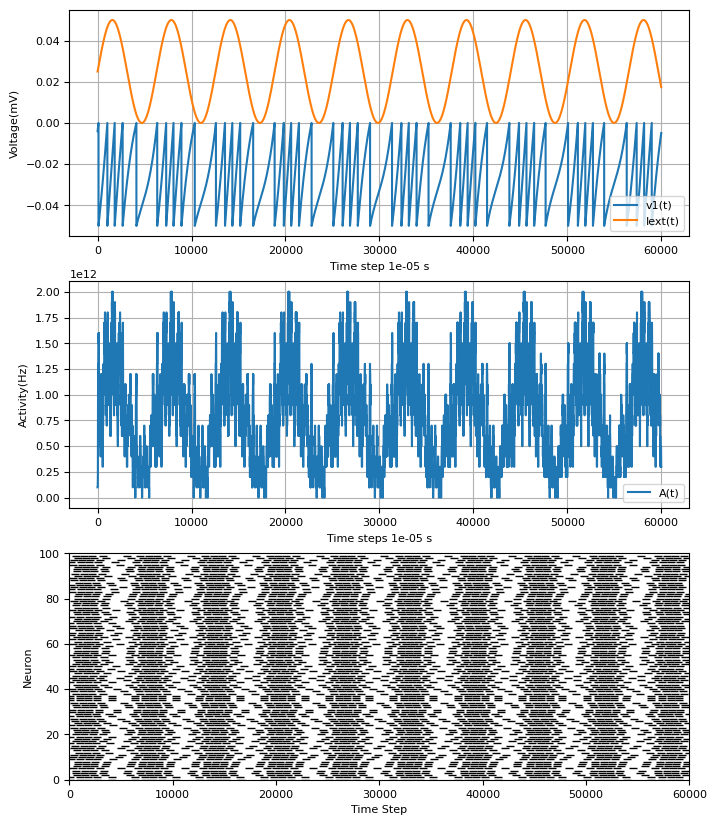

In [692]:
steps = Vs0.shape[0]
t = np.arange(0, steps, 1)
Ie0 = Iext(t, unit_time=dt)*MEMBRANE_RESISTANCE
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
IV_plot(Ie0, Vs0,t, ax1)
activity_plot(ST0,t,ax2)
raster_plot(ST0, ax3)

# Answer question exo-0-q2

# Exercice 1
## Question 1

In [918]:

tepsilon = 2*b2.ms
J = 2000*b2.mV
delta = 5*b2.ms
                
def synchronous_state(vi, T=600*b2.ms,unit_time=b2.ms, I=0*b2.mA):
    steps = int(T/unit_time)+1    
    spike_train = np.zeros((steps, len(vi))).astype(bool)
    voltages = np.zeros((steps, len(vi)))

    voltages[0] = vi
    epsilonA = np.zeros(steps)
    epsilonB = np.zeros(steps)
    for i in range(0,steps-1):

      voltages[i+1]= voltages[i]*1e3*b2.mV+unit_time*(-(voltages[i]*1e3*b2.mV-V_REST-MEMBRANE_RESISTANCE*I)+MEMBRANE_TIME_SCALE*J*epsilonA[i-int(delta/unit_time)]*b2.Hz) / MEMBRANE_TIME_SCALE
      firing = escape_function(voltages[i]*1e3*b2.mV)*unit_time
      voltages[i+1]+=(V_RESET-voltages[i]*1e3*b2.mV)*firing
      spike_train[i]=firing
      if i*unit_time > delta:
        epsilonB[i+1] = unit_time*(-epsilonB[i]+np.mean(spike_train[i]))/tepsilon+epsilonB[i]
        epsilonA[i+1] = unit_time*(-epsilonA[i]+epsilonB[i])/tepsilon+epsilonA[i]
        #print("ep", epsilonB[i], epsilonA[i],MEMBRANE_TIME_SCALE*J*epsilonA[i]*1e3*b2.Hz, np.mean(voltages[i])*1e3*b2.mV)
    return voltages, spike_train

In [919]:
N = 100
dt = 1e-2*b2.ms
Vi1 = np.random.uniform(V_RESET,FIRING_THRESHOLD,N)
Vs1, ST1 = synchronous_state(Vi1, unit_time=dt, T=600*b2.ms)

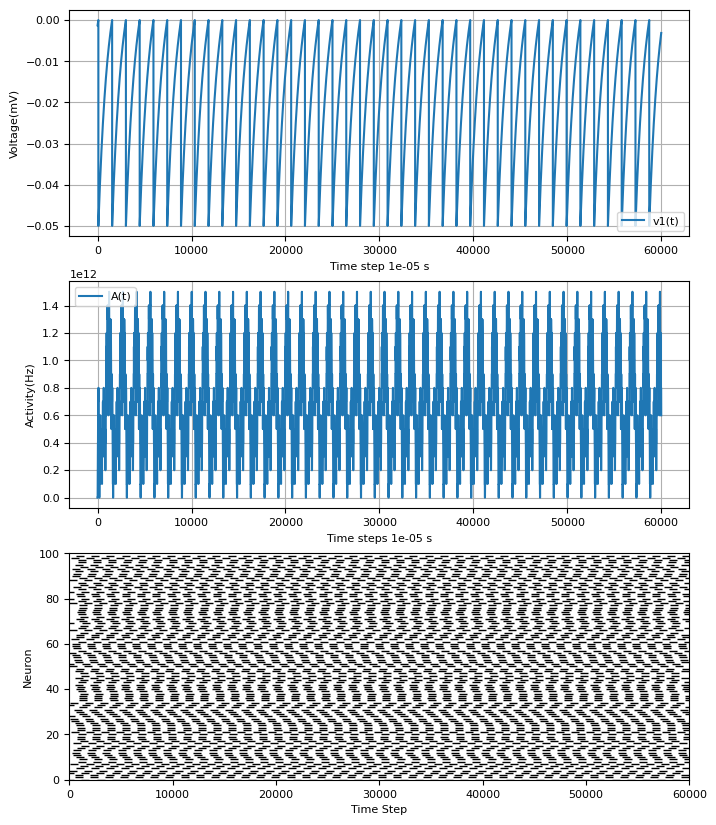

In [920]:
steps = Vs1.shape[0]
t = np.arange(0, steps, 1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
IV_plot(None, Vs1,t, ax1)
activity_plot(ST1,t,ax2)
raster_plot(ST1, ax3)

## Question 2

In [895]:
i30=np.round(200*b2.ms/dt).astype(int)
i200=np.round(200*b2.ms/dt).astype(int)

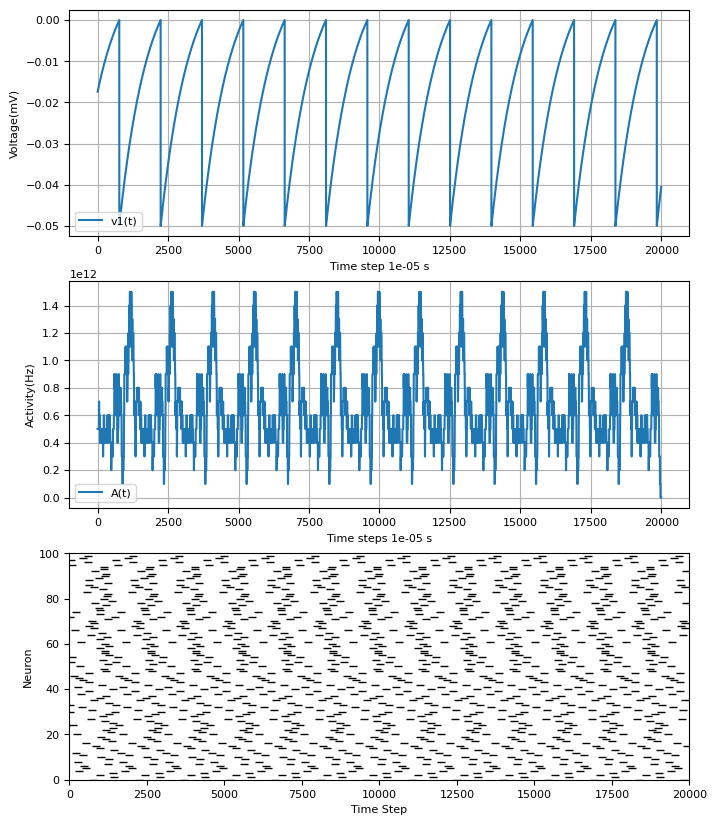

In [902]:
steps = Vs1.shape[0]
t = np.arange(0, steps, 1)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
IV_plot(None, Vs1[0:i200,:],t[0:i200], ax1)
activity_plot(ST1[0:i200,:],t[0:i200],ax2)
raster_plot(ST1[0:i200,:], ax3)

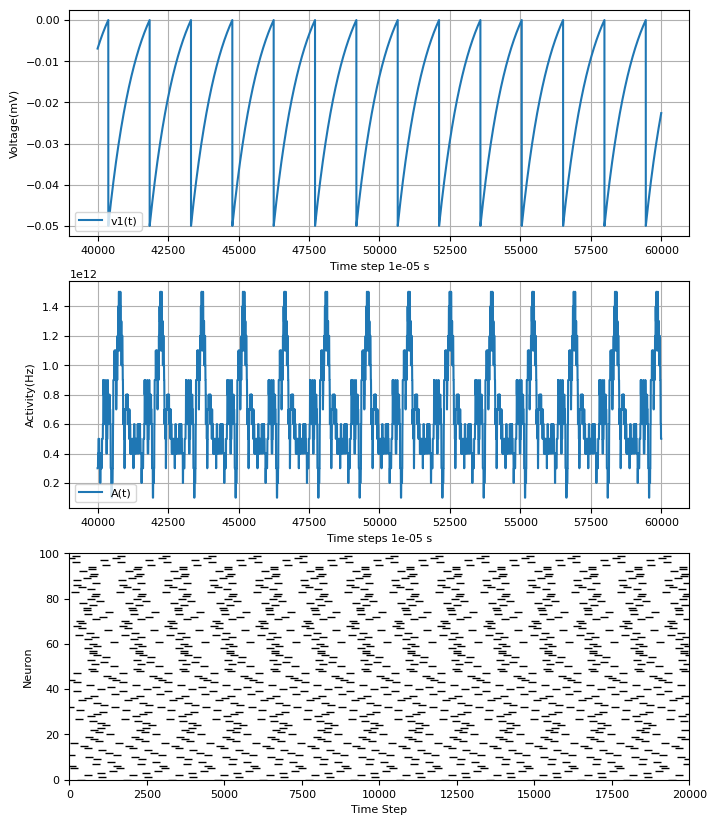

In [903]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
IV_plot(None, Vs1[-1-i30:-1],t[-1-i30:-1], ax1)
activity_plot(ST1[-1-i30:-1],t[-1-i30:-1],ax2)
raster_plot(ST1[-1-i30:-1], ax3)

## Question 3

In [898]:
N = 100
dt = 1e-2*b2.ms
Vi2 = np.random.uniform(V_RESET,FIRING_THRESHOLD,N)
Vs2, ST2 = synchronous_state(Vi2, unit_time=dt, T=600*b2.ms, I=-0.25*b2.mA)

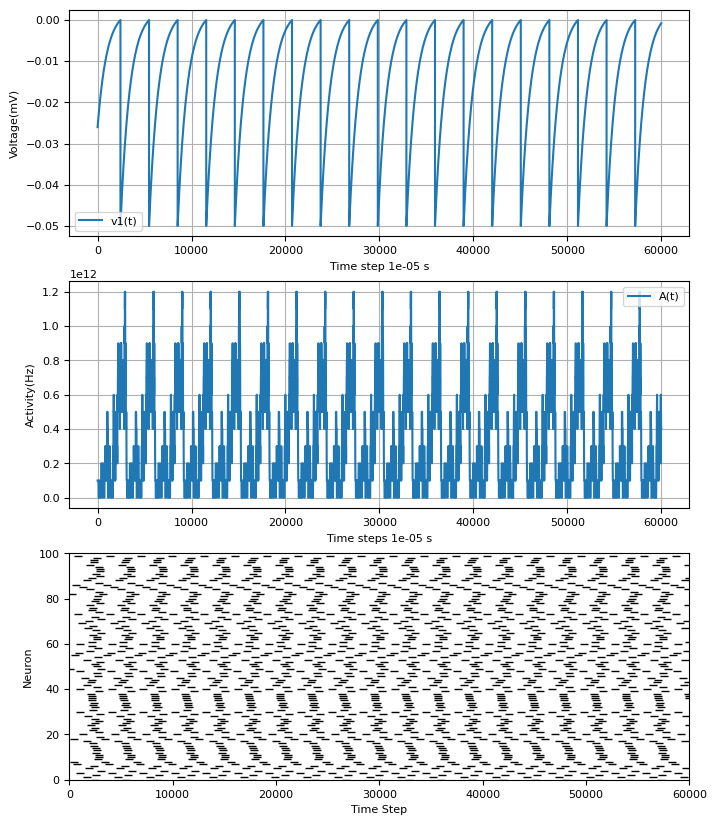

In [904]:
steps = Vs1.shape[0]
t = np.arange(0, steps, 1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
IV_plot(None, Vs2,t, ax1)
activity_plot(ST2,t,ax2)
raster_plot(ST2, ax3)

In [717]:
ST=ST1
t1 = np.min(np.nonzero(ST[:,0]))
rtimes= [np.min(np.nonzero(ST[:,i])[0][(np.nonzero(ST[:,i])>t1)[0]]) for i in range(1,ST.shape[1])]-t1
# for t1 in np.nonzero(ST[:,0])[0][1:-1]:
#   rtimes= np.vstack([rtimes,[np.min(np.nonzero(ST[:,i])[0][(np.nonzero(ST[:,i])>t1)[0]]) for i in range(1,ST.shape[1])] - t1])


(array([0.00517823, 0.00183744, 0.00100224, 0.0008352 , 0.00050112,
        0.00050112, 0.00050112, 0.00050112, 0.00050112, 0.00100224]),
 array([ 573. ,  653.9,  734.8,  815.7,  896.6,  977.5, 1058.4, 1139.3,
        1220.2, 1301.1, 1382. ]),
 <BarContainer object of 10 artists>)

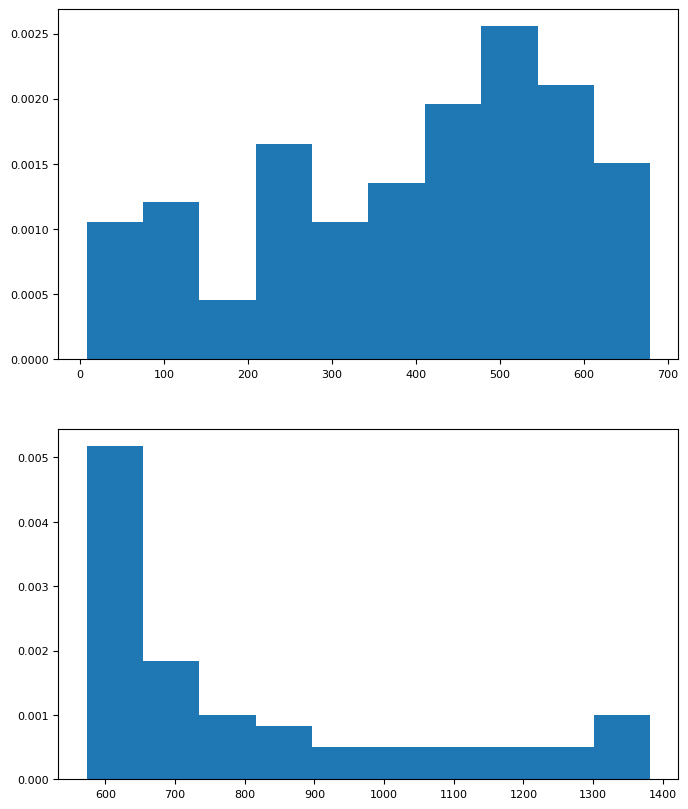

In [718]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.hist(rtimes.flatten(), density=True)
ax2.hist(np.diff(np.nonzero(ST[:,0]))[0], density=True)

In [720]:
ST=ST2
t1 = np.min(np.nonzero(ST[:,0]))
rtimes= [np.min(np.nonzero(ST[:,i])[0][(np.nonzero(ST[:,i])>t1)[0]]) for i in range(1,ST.shape[1])]-t1
#for t1 in np.nonzero(ST[:,0])[0][1:-1]:
#  rtimes= np.vstack([rtimes,[np.min(np.nonzero(ST[:,i])[0][(np.nonzero(ST[:,i])>t1)[0]]) for i in range(1,ST.shape[1])] - t1])

(array([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.]),
 array([3043.5, 3043.6, 3043.7, 3043.8, 3043.9, 3044. , 3044.1, 3044.2,
        3044.3, 3044.4, 3044.5]),
 <BarContainer object of 10 artists>)

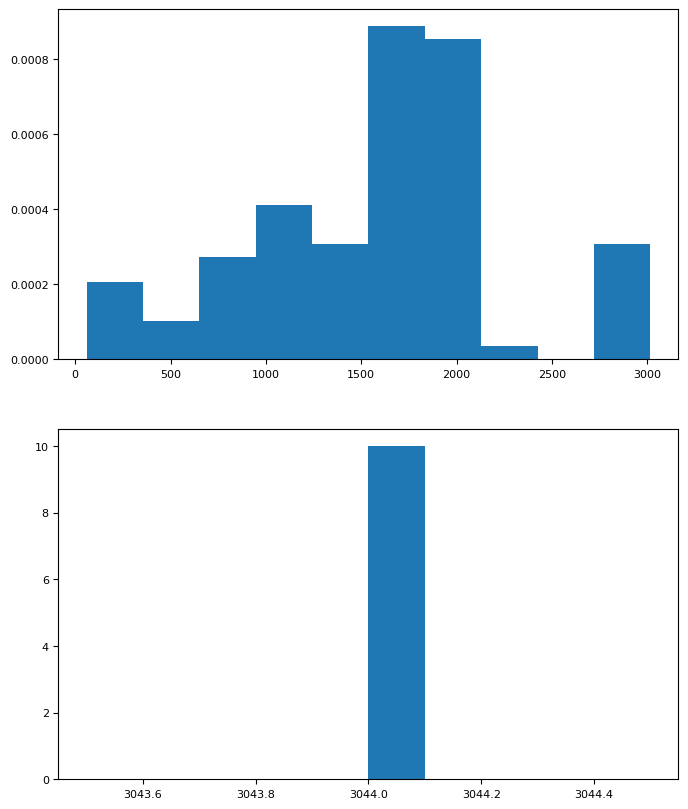

In [721]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.hist(rtimes.flatten(), density=True)
ax2.hist(np.diff(np.nonzero(ST[:,0]))[0], density=True)

In [ ]:
steps = Vs1.shape[0]
t = np.arange(0, steps, 1)
Ie3 = Iext(t, unit_time=dt)*MEMBRANE_RESISTANCE

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
IV_plot(Ie2, Vs2,t, ax1)
activity_plot(ST2,t,ax2)
raster_plot(ST2, ax3)